In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import prince

from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, PolynomialFeatures, StandardScaler, SplineTransformer, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc, recall_score, precision_recall_curve, make_scorer
from sklearn.kernel_approximation import Nystroem
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced

from prince import FAMD

from scipy.stats import chi2_contingency

from yellowbrick.classifier import DiscriminationThreshold
from sklego.meta import Thresholder

In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [3]:
print(df.shape)

(447136, 41)


In [4]:
data = df.drop(['grav_rec', 'an', 'jour', 'date', 'grav', 'dep'], axis=1)
y = df.grav
numerical_features = ['age_usager', 'mois', 'heure', 'lat', 'long']
categorical_features = [col for col in data.columns if col not in numerical_features]
data[categorical_features] = data[categorical_features].astype('object')
#data.info()

In [5]:
data.head()

,mois,lum,agg,int,atm,col,lat,long,catr,circ,...,eq_ceinture,eq_casque,eq_siege,eq_gilet,eq_airbag,eq_gants,eq_indetermine,eq_autre,jour_chome,prox_pt_choc
0,11,2.0,0,0.0,0.0,2.0,48.896210,2.470120,1,0.0,...,1,0,0,0,0,0,0,0,1,0
1,11,2.0,0,0.0,0.0,2.0,48.896210,2.470120,1,0.0,...,1,0,0,0,0,0,0,0,1,0
2,11,2.0,0,0.0,0.0,2.0,48.896210,2.470120,1,0.0,...,1,0,0,0,0,0,0,0,1,1
3,11,2.0,0,0.0,0.0,6.0,48.930700,2.368800,1,0.0,...,1,0,0,0,0,0,0,0,1,1
4,11,0.0,0,0.0,0.0,4.0,48.935872,2.319174,1,0.0,...,1,0,0,0,0,0,0,0,1,1


In [6]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42, stratify=y)

df[['heure', '']]

In [7]:
class TransfoHour(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo[f'{self.column_name}_cos'] = np.cos(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo
    
    def get_feature_names_out(self):
        pass
    
class TransfoMonth(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo[f'{self.column_name}_cos'] = np.cos((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass
    

In [8]:
preprocessor = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', StandardScaler(), ['age_usager']),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ['place_rec','catr', 'surf', 'infra', 'situ', 'motor', 'manv', 'obsm', 'catv', 'col', 'lum'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

logistic_regression = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, multi_class='ovr', class_weight='balanced'))])

In [9]:
logistic_regression

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transfo_heure',
                                                  TransfoHour(column_name='heure'),
                                                  ['heure']),
                                                 ('transfo_mois',
                                                  TransfoMonth(column_name='mois'),
                                                  ['mois']),
                                                 ('transfo_lat_long',
                                                  RobustScaler(),
                                                  ['lat', 'long']),
                                                 ('transfo_age_usager',
                                                  StandardScaler(),
                                                  ['age_usager']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['place_rec', 'catr', 'surf',
                                                   'infra', 'situ', 'motor',
                                                   'manv', 'obsm', 'catv',
                                                   'col', 'lum'])])),
                ('log_reg',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    multi_class='ovr'))])

In [9]:
f1 = make_scorer(f1_score, average='micro')
cv_results = cross_validate(logistic_regression, data, y, cv=3, 
                            return_estimator=True, return_train_score=True, scoring=f1,
                            verbose=10)
cv_results = pd.DataFrame(cv_results)
cv_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ..................., score=(train=0.600, test=0.605) total time= 1.5min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] END ..................., score=(train=0.601, test=0.597) total time= 1.3min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min remaining:    0.0s


[CV] END ..................., score=(train=0.601, test=0.594) total time= 1.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.3min finished


,fit_time,score_time,estimator,test_score,train_score
0,86.156250,2.396554,"(ColumnTransformer(remainder='passthrough',\n ...",0.605390,0.599832
1,76.869536,1.783667,"(ColumnTransformer(remainder='passthrough',\n ...",0.597350,0.600951
2,74.961585,2.258637,"(ColumnTransformer(remainder='passthrough',\n ...",0.594297,0.601484


In [10]:
logistic_regression = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, multi_class='ovr', class_weight='balanced'))])
logistic_regression.fit(data_train, y_train)
y_pred = logistic_regression.predict(data_test)
cr = classification_report(y_test, y_pred)
print(cr)
pd.crosstab(y_test, y_pred)

              precision    recall  f1-score   support

         1.0       0.71      0.81      0.76     46137
         2.0       0.14      0.46      0.21      3050
         3.0       0.41      0.41      0.41     17500
         4.0       0.68      0.48      0.56     45097

    accuracy                           0.60    111784
   macro avg       0.48      0.54      0.48    111784
weighted avg       0.63      0.60      0.61    111784



col_0,1.0,2.0,3.0,4.0
grav,,,,
1.0,37212,1973,2079,4873
2.0,255,1412,1003,380
3.0,1932,3575,7097,4896
4.0,12986,3423,7194,21494


**Ajout d'un undersampler**

In [11]:
preprocessor = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', StandardScaler(), ['age_usager']),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ['place_rec','catr', 'surf', 'infra', 'situ', 'motor', 'manv', 'obsm', 'catv', 'col', 'lum'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

logistic_regression = Pipeline(steps=[("undersampler", RandomUnderSampler(sampling_strategy="auto")),
                                      ("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, multi_class='ovr', class_weight='balanced'))])

In [12]:
f1 = make_scorer(f1_score, average='micro')
cv_results = cross_validate(logistic_regression, data, y, cv=3, 
                            return_estimator=True, return_train_score=True, scoring=f1,
                            verbose=10)
cv_results = pd.DataFrame(cv_results)
cv_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ..................., score=(train=0.568, test=0.574) total time=  12.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.9s remaining:    0.0s


[CV] END ..................., score=(train=0.570, test=0.565) total time=  12.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.8s remaining:    0.0s


[CV] END ..................., score=(train=0.571, test=0.562) total time=  12.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.8s finished


,fit_time,score_time,estimator,test_score,train_score
0,10.694814,2.059681,"(RandomUnderSampler(), ColumnTransformer(remai...",0.574225,0.567825
1,10.299831,1.809824,"(RandomUnderSampler(), ColumnTransformer(remai...",0.565091,0.569652
2,10.183079,1.883942,"(RandomUnderSampler(), ColumnTransformer(remai...",0.562219,0.570601


*Baisse des performances avec l'undersampler*

**Influence de multi_class sur les résultats**

In [13]:
preprocessor = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', StandardScaler(), ['age_usager']),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ['place_rec','catr', 'surf', 'infra', 'situ', 'motor', 'manv', 'obsm', 'catv', 'col', 'lum'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

logistic_regression = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, multi_class='auto', class_weight='balanced'))])

In [14]:
f1 = make_scorer(f1_score, average='micro')
cv_results = cross_validate(logistic_regression, data, y, cv=3, 
                            return_estimator=True, return_train_score=True, scoring=f1,
                            verbose=10)
cv_results = pd.DataFrame(cv_results)
cv_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ..................., score=(train=0.572, test=0.579) total time= 1.3min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] END ..................., score=(train=0.572, test=0.569) total time= 1.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV] END ..................., score=(train=0.573, test=0.564) total time= 1.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.8min finished


,fit_time,score_time,estimator,test_score,train_score
0,74.336038,2.088191,"(ColumnTransformer(remainder='passthrough',\n ...",0.579090,0.571988
1,66.691042,1.693288,"(ColumnTransformer(remainder='passthrough',\n ...",0.568640,0.571745
2,67.856591,1.943316,"(ColumnTransformer(remainder='passthrough',\n ...",0.564118,0.573020


Le modèle s'en sort mieux en mode One-vs-Rest

**Hyperparameter tuning**

In [15]:
logistic_regression = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, multi_class='ovr', class_weight='balanced'))])
param_grid =[{"log_reg__solver": ['liblinear'],"log_reg__penalty": ['l1'], "log_reg__C" : [10**(i) for i in range(-2,2)]},
             {"log_reg__solver": ['newton-cg'],"log_reg__penalty": ['l2'], "log_reg__C" : [10**(i) for i in range(-2,2)]}]

f1 = make_scorer(f1_score, average='micro')
model_gds = GridSearchCV(logistic_regression,
                                         param_grid=param_grid,
                                         scoring=f1,                                
                                         cv=2,
                                         return_train_score=True,
                                         verbose=10)
model_gds.fit(data_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2; 1/8] START log_reg__C=0.01, log_reg__penalty=l1, log_reg__solver=liblinear
[CV 1/2; 1/8] END log_reg__C=0.01, log_reg__penalty=l1, log_reg__solver=liblinear;, score=(train=0.622, test=0.618) total time=  19.5s
[CV 2/2; 1/8] START log_reg__C=0.01, log_reg__penalty=l1, log_reg__solver=liblinear
[CV 2/2; 1/8] END log_reg__C=0.01, log_reg__penalty=l1, log_reg__solver=liblinear;, score=(train=0.617, test=0.618) total time=  20.3s
[CV 1/2; 2/8] START log_reg__C=0.1, log_reg__penalty=l1, log_reg__solver=liblinear
[CV 1/2; 2/8] END log_reg__C=0.1, log_reg__penalty=l1, log_reg__solver=liblinear;, score=(train=0.623, test=0.620) total time= 1.9min
[CV 2/2; 2/8] START log_reg__C=0.1, log_reg__penalty=l1, log_reg__solver=liblinear
[CV 2/2; 2/8] END log_reg__C=0.1, log_reg__penalty=l1, log_reg__solver=liblinear;, score=(train=0.620, test=0.621) total time= 1.0min
[CV 1/2; 3/8] START log_reg__C=1, log_reg__penalty=l1, log_reg__solv

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('transfo_heure',
                                                                         TransfoHour(column_name='heure'),
                                                                         ['heure']),
                                                                        ('transfo_mois',
                                                                         TransfoMonth(column_name='mois'),
                                                                         ['mois']),
                                                                        ('transfo_lat_long',
                                                                         RobustScaler(),
                                                                         ['lat',
                                                                          'long']),
                                                                        ('transfo_age_usager',
                                                                         StandardScaler(),
                                                                         ['age_usager']),
                                                                        ('one_ho...
                                       ('log_reg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=5000,
                                                           multi_class='ovr'))]),
             param_grid=[{'log_reg__C': [0.01, 0.1, 1, 10],
                          'log_reg__penalty': ['l1'],
                          'log_reg__solver': ['liblinear']},
                         {'log_reg__C': [0.01, 0.1, 1, 10],
                          'log_reg__penalty': ['l2'],
                          'log_reg__solver': ['newton-cg']}],
             return_train_score=True,
             scoring=make_scorer(f1_score, average=micro), verbose=10)

In [16]:
cv_results = pd.DataFrame(model_gds.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log_reg__C,param_log_reg__penalty,param_log_reg__solver,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,17.261095,0.215126,2.751956,0.193691,0.01,l1,liblinear,"{'log_reg__C': 0.01, 'log_reg__penalty': 'l1',...",0.618282,0.618461,0.618371,0.000089,4,0.621508,0.617232,0.619370,0.002138
1,86.378615,26.513134,2.936786,0.039426,0.1,l1,liblinear,"{'log_reg__C': 0.1, 'log_reg__penalty': 'l1', ...",0.620113,0.620876,0.620494,0.000382,1,0.623226,0.619791,0.621508,0.001718
2,234.143935,16.801030,3.408026,0.284234,1,l1,liblinear,"{'log_reg__C': 1, 'log_reg__penalty': 'l1', 'l...",0.619964,0.620667,0.620315,0.000352,2,0.622975,0.620089,0.621532,0.001443
3,59.805395,34.471744,2.597146,0.073680,10,l1,liblinear,"{'log_reg__C': 10, 'log_reg__penalty': 'l1', '...",0.619874,0.620530,0.620202,0.000328,3,0.622951,0.620035,0.621493,0.001458
4,34.573447,0.418941,3.022629,0.163244,0.01,l2,newton-cg,"{'log_reg__C': 0.01, 'log_reg__penalty': 'l2',...",0.598607,0.597999,0.598303,0.000304,8,0.601028,0.597366,0.599197,0.001831
5,53.756984,1.710347,3.704560,0.760058,0.1,l2,newton-cg,"{'log_reg__C': 0.1, 'log_reg__penalty': 'l2', ...",0.599752,0.599269,0.599510,0.000242,7,0.602322,0.598595,0.600459,0.001864
6,71.524135,1.173463,2.424154,0.079525,1,l2,newton-cg,"{'log_reg__C': 1, 'log_reg__penalty': 'l2', 'l...",0.599758,0.599519,0.599639,0.000119,5,0.602269,0.598684,0.600477,0.001792
7,80.654902,14.932838,2.609583,0.048746,10,l2,newton-cg,"{'log_reg__C': 10, 'log_reg__penalty': 'l2', '...",0.599752,0.599472,0.599612,0.000140,6,0.602281,0.598637,0.600459,0.001822


In [17]:
model_gds.best_params_

{'log_reg__C': 0.1, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}

In [18]:
y_pred_best_est = model_gds.best_estimator_.predict(data_test)
cr = classification_report(y_test, y_pred_best_est)
print(cr)
pd.crosstab(y_test, y_pred_best_est)

              precision    recall  f1-score   support

         1.0       0.70      0.82      0.76     46137
         2.0       0.16      0.37      0.22      3050
         3.0       0.44      0.36      0.40     17500
         4.0       0.66      0.54      0.59     45097

    accuracy                           0.62    111784
   macro avg       0.49      0.52      0.49    111784
weighted avg       0.63      0.62      0.62    111784



col_0,1.0,2.0,3.0,4.0
grav,,,,
1.0,37877,1183,1690,5387
2.0,356,1143,1017,534
3.0,2293,2589,6283,6335
4.0,13439,2254,5214,24190


In [11]:
logistic_regression = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, multi_class='ovr', class_weight='balanced', C=0.1, penalty='l1', solver='liblinear'))])
logistic_regression.fit(data_train, y_train)
y_pred = logistic_regression.predict(data_test)
cr = classification_report_imbalanced(y_test, y_pred)
print(cr)

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.70      0.82      0.75      0.76      0.79      0.62     46137
        2.0       0.16      0.37      0.94      0.22      0.59      0.33      3050
        3.0       0.44      0.36      0.92      0.40      0.57      0.31     17500
        4.0       0.66      0.54      0.82      0.59      0.66      0.43     45097

avg / total       0.63      0.62      0.81      0.62      0.70      0.49    111784



**Interprétabilité**

*Analyse des coefficients de la régression logistique*

In [19]:
logistic_regression = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, multi_class='ovr', class_weight='balanced',
                                                                     solver='liblinear', C=0.1, penalty='l1'))])

In [20]:
f1 = make_scorer(f1_score, average='micro')
cv_results = cross_validate(logistic_regression, data, y, cv=3, 
                            return_estimator=True, return_train_score=True, scoring=f1,
                            verbose=10)
cv_results = pd.DataFrame(cv_results)
cv_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ..................., score=(train=0.620, test=0.624) total time= 3.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s


[CV] END ..................., score=(train=0.622, test=0.619) total time= 2.6min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.9min remaining:    0.0s


[CV] END ..................., score=(train=0.622, test=0.616) total time= 3.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.9min finished


,fit_time,score_time,estimator,test_score,train_score
0,186.285349,1.892542,"(ColumnTransformer(remainder='passthrough',\n ...",0.624042,0.620155
1,152.832242,3.443678,"(ColumnTransformer(remainder='passthrough',\n ...",0.619001,0.621659
2,232.853521,2.125466,"(ColumnTransformer(remainder='passthrough',\n ...",0.616022,0.622481


In [21]:
data_preproc = preprocessor.fit_transform(data_train, y_train)

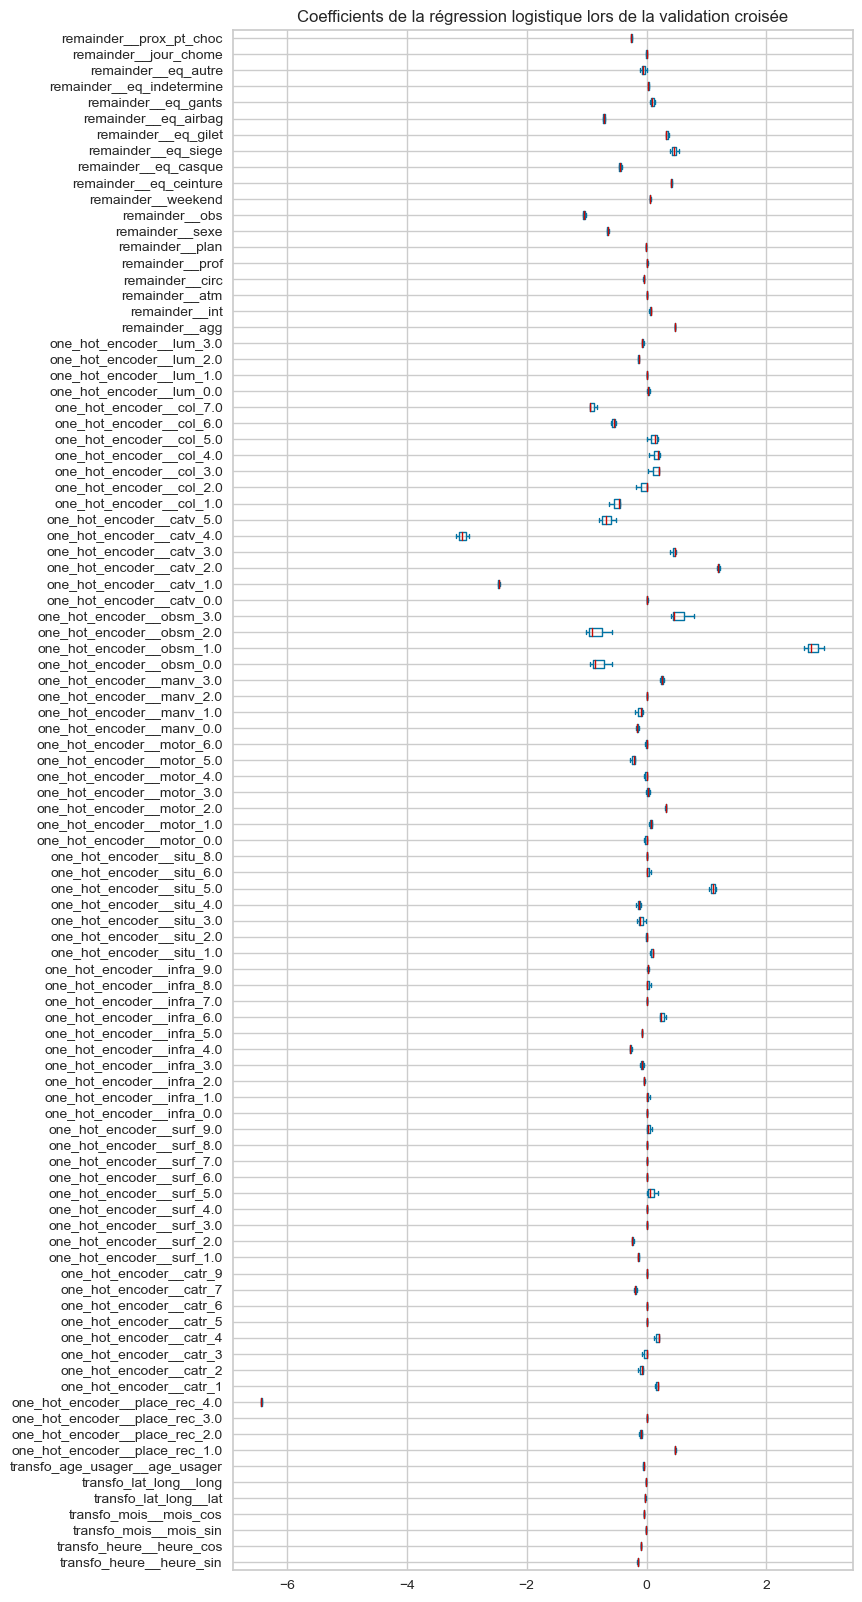

In [22]:
coefs = [est[-1].coef_[0] for est in cv_results["estimator"]]
weights_logreg = pd.DataFrame(coefs, columns = data_preproc.columns)

fig, ax = plt.subplots(figsize=(8,20));
weights_logreg.plot.box(vert=False, ax=ax);
plt.title('Coefficients de la régression logistique lors de la validation croisée');

*Analyse factorielle*

In [23]:

famd = FAMD(n_components=data_preproc.columns.shape[0])
essai_famd = famd.fit(data_preproc)

<Axes: >

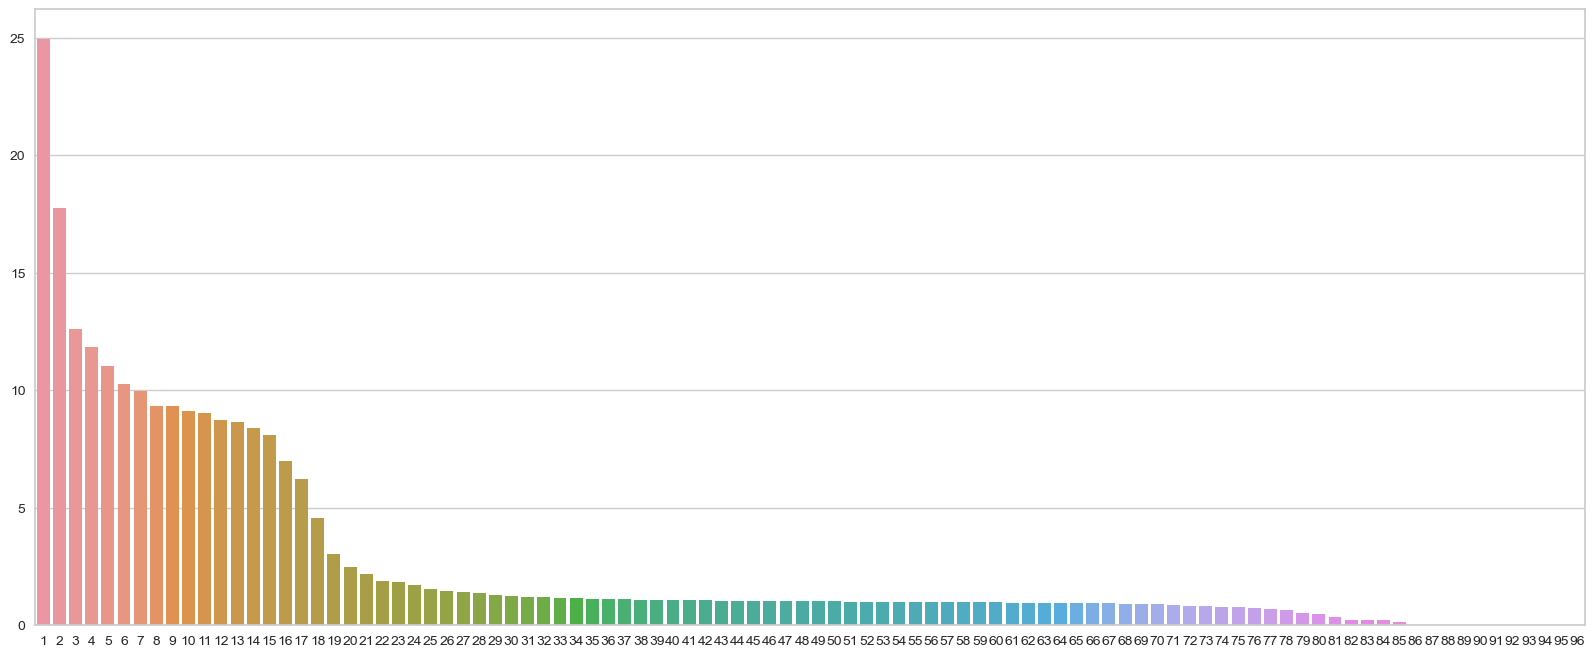

In [24]:
figure = plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(1,data_preproc.shape[1]+1), y=famd.eigenvalues_)

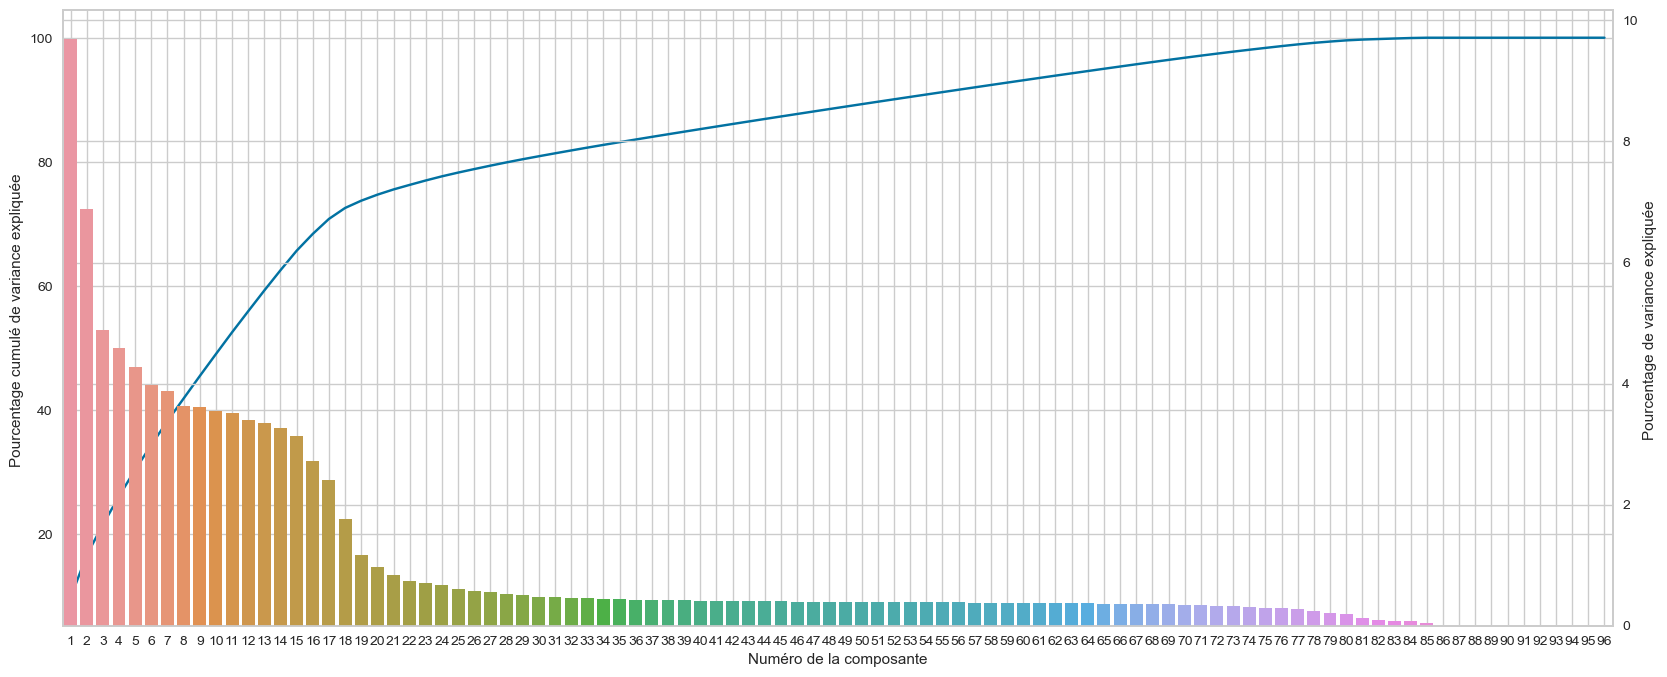

In [25]:
figure = plt.figure(figsize=(20,8))
ax = figure.add_subplot(111)
ax.plot(famd.cumulative_percentage_of_variance_);
ax.set_xlabel("Numéro de la composante");
ax.set_ylabel("Pourcentage cumulé de variance expliquée ");

ax2 = ax.twinx()
sns.barplot(x=np.arange(1,data_preproc.shape[1]+1),y=famd.percentage_of_variance_, ax=ax2)
ax2.set_ylabel("Pourcentage de variance expliquée ");


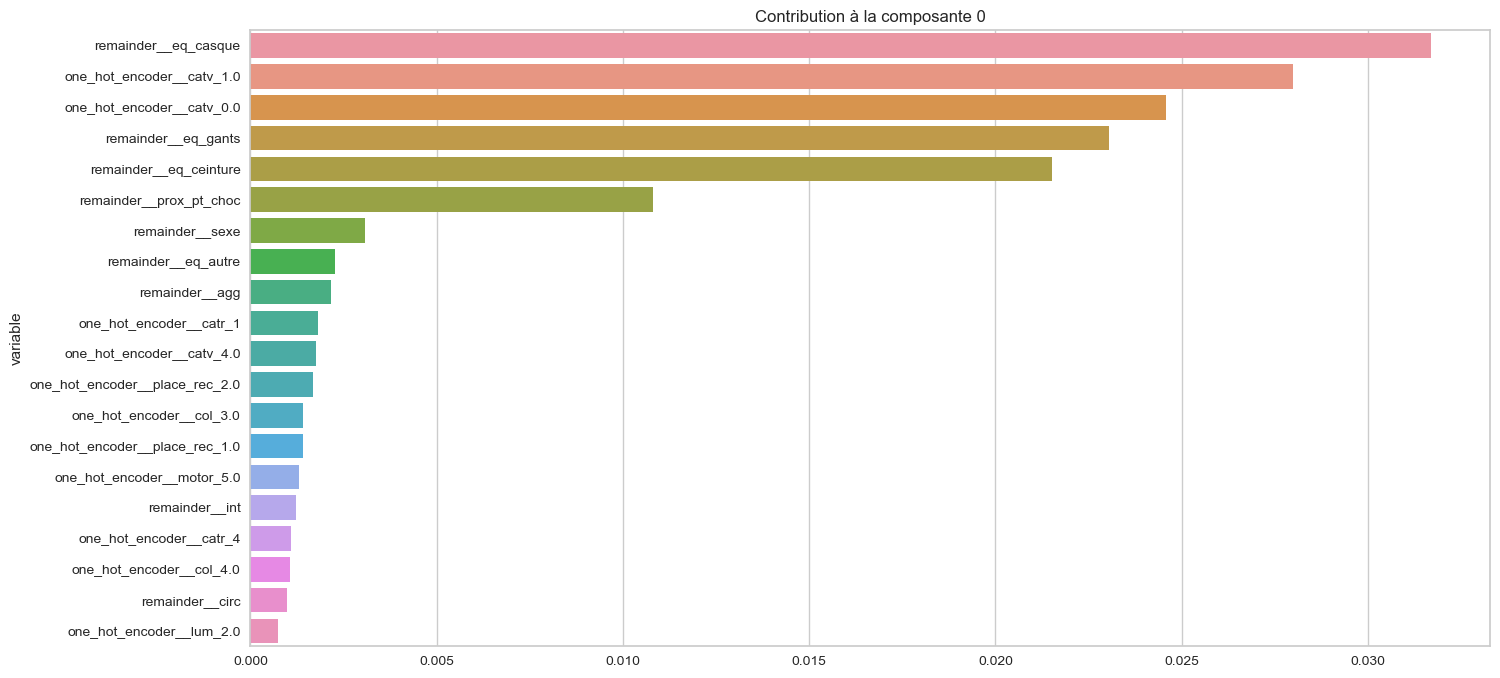

In [26]:
comp_ret = 0
df = essai_famd.column_contributions_.iloc[:,comp_ret].sort_values(ascending=False)
plt.figure(figsize=(16,8));
plt.title(f'Contribution à la composante {comp_ret}');
sns.barplot(y=df.index[:20],x=df.values[:20]);

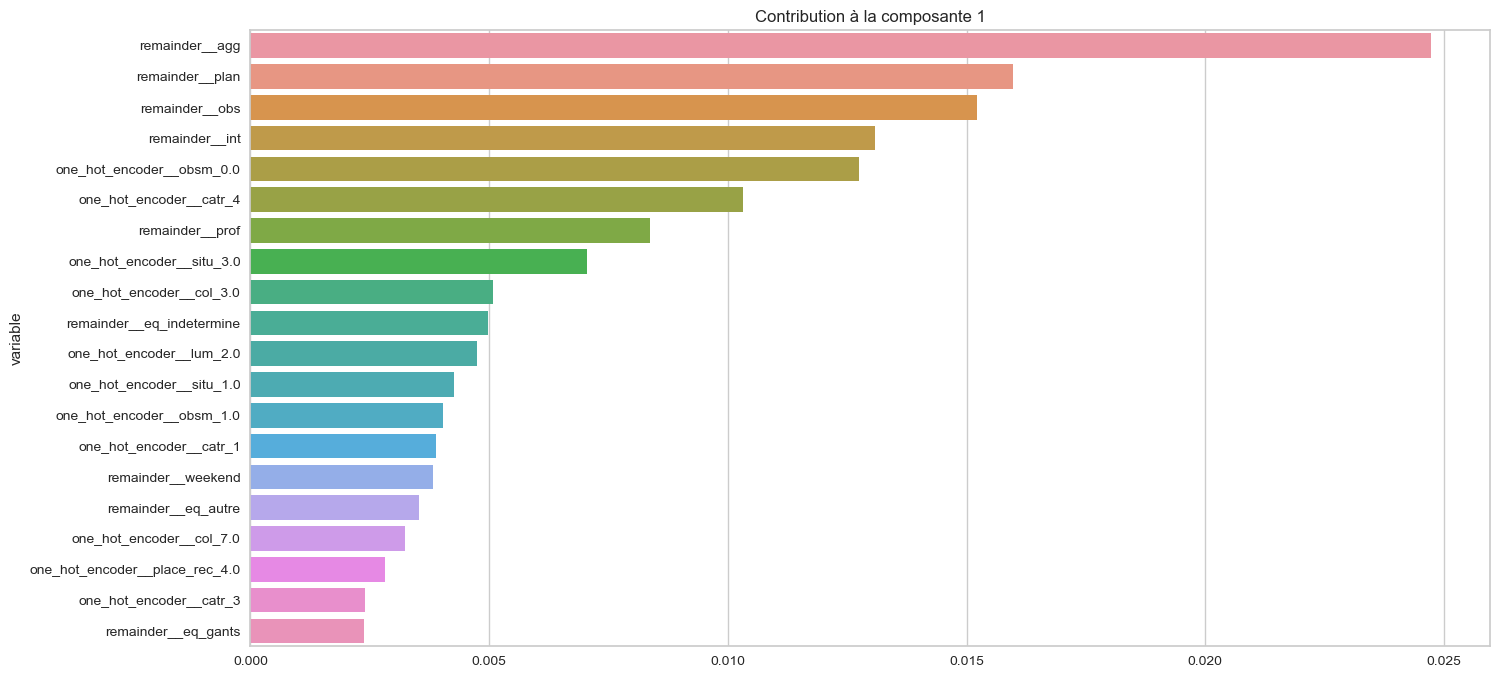

In [27]:
comp_ret = 1
df = essai_famd.column_contributions_.iloc[:,comp_ret].sort_values(ascending=False)
plt.figure(figsize=(16,8));
plt.title(f'Contribution à la composante {comp_ret}');
sns.barplot(y=df.index[:20],x=df.values[:20]);

<Axes: xlabel='0', ylabel='Count'>

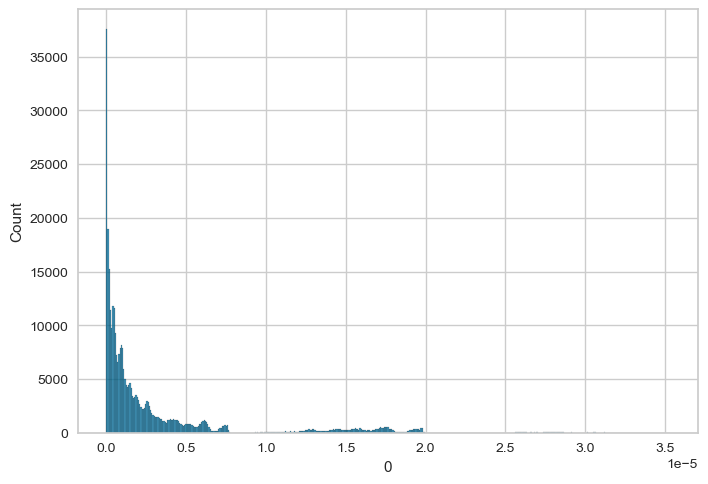

In [28]:
sns.histplot(famd.row_contributions_[0])